In [1]:
%env CUDA_VISIBLE_DEVICES=4
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=4
env: OMP_NUM_THREADS=16


In [2]:
import torch
torch.set_grad_enabled(False)

In [3]:
from fast_hadamard_transform import hadamard_transform

class NoisyHadamarLinear(torch.nn.Module):
    def __init__(self, weight, bias, *, had_block_size = 2048, relative_mse = 0):
        super().__init__()

        weight = weight.detach().clone()
        if bias is not None:
            bias = bias.detach().clone()

        self.had_block_size = had_block_size

        self.out_features, self.in_features = weight.shape

        self.inner = torch.nn.Linear(self.in_features, self.out_features, bias=(bias is not None), dtype=weight.dtype,
                                     device=weight.device)

        assert self.in_features % self.had_block_size == 0, (self.in_features, self.had_block_size)
        weight = weight.reshape(self.out_features, self.in_features // self.had_block_size, self.had_block_size)
        weight = hadamard_transform(weight, scale=1 / (self.had_block_size ** 0.5))
        weight = weight.reshape(self.out_features, self.in_features)

        weight = weight + torch.randn_like(weight) * torch.norm(weight) * (relative_mse ** 0.5) / (weight.numel() ** 0.5)



        self.inner.weight.data = weight
        if bias is not None:
            self.inner.bias.data = bias

    def forward(self, input):
        input_shape = input.shape

        assert input.shape[-1] % self.had_block_size == 0

        input = input.reshape(-1, self.had_block_size)
        input = hadamard_transform(input, scale=1 / (self.had_block_size ** 0.5))
        input = input.reshape(input_shape)

        return self.inner(input)

In [4]:
from transformers import AutoModelForCausalLM

MODEL_PATH = '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/13f04ed6f85ef2aa2fd11b960a275c3e31a8069e/'
MODEL_SEQLEN = 8192
BASE_PPL = 5.606692790985107

model_pt_orig = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True, torch_dtype="auto", device_map='cuda',
).half()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
from eval import *

testloader = get_loaders(
    'wikitext2',
    seed=0,
    model_path=MODEL_PATH,
    seqlen=MODEL_SEQLEN,
    eval_mode=True,
    use_fast_tokenizer=False,
    trust_remote_code=False,
)

def eval_ppl(
    model,
    model_path=MODEL_PATH,
    model_seqlen=MODEL_SEQLEN,
    device = 'cuda:0',
    # ppl_datasets = ('wikitext2',),
    trust_remote_code=False,
    offload_activations=False,
):
    output = {}
    
    ppl = perplexity_eval(
        model,
        testloader,
        dataset_name='wikitext2',
        model_seqlen=model_seqlen,
        device=device,
        offload_activations=offload_activations,
    )
    output['wikitext2'] = ppl
    # make sure that the cache is released
    torch.cuda.empty_cache()
    
    return output

Token indices sequence length is longer than the specified maximum sequence length for this model (289076 > 131072). Running this sequence through the model will result in indexing errors


In [6]:
import copy
import torch

NF4_CODES = torch.tensor([
    -1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453, -0.28444138169288635, -0.18477343022823334,
    -0.09105003625154495, 0.0,
    0.07958029955625534, 0.16093020141124725, 0.24611230194568634, 0.33791524171829224, 0.44070982933044434,
    0.5626170039176941, 0.7229568362236023, 1.0,
], dtype=torch.float16)


def get_closest_idx(x, grid):
    _grid_len, = grid.shape
    input_shape = x.shape
    x = x.reshape(-1)

    output = (x[:, None] - grid[None, :]).abs().min(dim=1).indices
    assert output.shape == x.shape

    return output.reshape(input_shape)


def quantize_weight(weight, block_size=64, codes=NF4_CODES):
    out_dim, in_dim = weight.shape
    
    codes = copy.deepcopy(codes).to(weight.device)

    weight_groups = weight.reshape(-1, block_size)

    scales = weight_groups.abs().max(dim=1).values

    assert scales.shape == (out_dim * in_dim // block_size,)
    weight_quantized = get_closest_idx(
        weight_groups / scales[:, None],
        codes,
    ).reshape(out_dim, in_dim).to(weight.device)

    return weight_quantized, scales


def dequantize_weight(weight_quantized, scales, block_size = 64, codes=NF4_CODES):
    out_dim, in_dim = weight_quantized.shape
    
    codes = copy.deepcopy(codes).to(weight_quantized.device)

    return (
        codes[weight_quantized].reshape(-1, block_size) *
        scales[:, None]
    ).reshape(out_dim, in_dim)


def quantize_dequantize_weight(weight, block_size=64, codes=NF4_CODES):
    weight_quantized, scales = quantize_weight(weight, block_size=block_size, codes=codes)
    scales = scales.half()
    return dequantize_weight(weight_quantized, scales, block_size=block_size, codes=codes)

In [7]:
def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

def set_module_by_path(model, path, value):
    parts = path.split('.')
    prefix = '.'.join(parts[:-1])
    parent = get_module_by_path(model, prefix)
    setattr(parent, parts[-1], value)

In [8]:
layers = sorted([
    name for name, value in
    model_pt_orig.named_modules() if (
        isinstance(value, nn.Linear) and
        name.startswith('model.layers')
    )
])

In [9]:
model_pt_orig = model_pt_orig.half().cuda()
# eval_ppl(model_pt_orig)

In [10]:
from functools import partial
import time

import numpy as np
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.stats import norm, halfnorm, truncnorm

def integrand(block_size, x, m):
    p_z_less_than_mx = truncnorm.cdf(m * x, -m, m)
    pm = block_size * (halfnorm.cdf(m) ** (block_size - 1)) * 2 * norm.pdf(m)

    return p_z_less_than_mx * pm

def scaled_norm_cdf(block_size, x):
    result = quad(
        partial(integrand, block_size, x),
        0,
        np.inf,
        epsabs=1e-9,
    )
    return result[0]

def cdf(x, block_size):
    discrete_mass = 1 / (2 * block_size)
    cont_mass = scaled_norm_cdf(block_size, x) * (block_size - 1) / block_size
    result = discrete_mass + cont_mass
    result = np.where(x < -1, 0, result)
    result = np.where(x >= 1, 1, result)
    return result

def inv_cdf(val, block_size):
    edge_mass  = 1 / (2 * block_size)
    if val <= edge_mass:
        return -1
    if val >= 1 - edge_mass:
        return 1
    def search_fn(x):
        return cdf(x, block_size) - val

    return root_scalar(search_fn, bracket=[-1, 1]).root

def build_code(start, lower_bound, upper_bound, n_steps, bcdf, binv_cdf, lower_bound_is_code_point=True):
    code = [start]
    a = lower_bound if lower_bound_is_code_point else None
    b = start
    prev_midpoint_prob = None
    for _ in range(n_steps):
        if prev_midpoint_prob is None:
            prev_midpoint_prob = bcdf((a + b) / 2) if lower_bound_is_code_point else 0
        prev_mass = bcdf(b) - prev_midpoint_prob

        next_midpoint_prob = bcdf(b) + prev_mass
        if next_midpoint_prob > 1:
            c = 1
        else:
            next_midpoint = binv_cdf(next_midpoint_prob)
            prev_midpoint_prob = next_midpoint_prob

            c = next_midpoint * 2 - b

            a = b
            b = c

        if c >= upper_bound:
            code.extend(upper_bound for _ in range(n_steps + 1 - len(code)))
            break

        code.append(c)

    return np.stack(code, -1)

def interval_code_search(
    lower_bound,
    upper_bound,
    n_steps,
    block_size,
    bounds_are_code_points=True,
):
    bcdf = partial(cdf, block_size=block_size)
    binv_cdf = partial(inv_cdf, block_size=block_size)

    code_builder = partial(
        build_code,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
        n_steps=n_steps,
        bcdf=bcdf,
        binv_cdf=binv_cdf,
        lower_bound_is_code_point=bounds_are_code_points
    )

    lower_bracket = lower_bound + (1e-5 if bounds_are_code_points else 0)

    lower_feasible = lower_bracket
    upper_feasible = upper_bound - 1e-5

    while upper_feasible - lower_feasible > 1e-4:
        mid = (lower_feasible + upper_feasible) / 2
        code = code_builder(mid)
        infeasible = np.any(code[1:] - code[:-1] <= 0) or any(code[:-1] >= upper_bound) or code[-1] > upper_bound
        if infeasible:
            upper_feasible = mid
        else:
            lower_feasible = mid

    upper_bracket = lower_feasible
    def search_fn(val):
        code = code_builder(val)
        top = code[-1]
        prev_split = (top + code[-2]) / 2

        top_prob = bcdf(top)
        target_prob = top_prob + (top_prob - bcdf(prev_split))
        return target_prob - 1/2

    opt_a2 = root_scalar(search_fn, bracket=[lower_bracket, upper_bracket]).root
    code = code_builder(opt_a2)
    return code

def construct_af4(block_size):
    lower =  interval_code_search(-1, 0, 5, block_size)
    upper = -interval_code_search(-1, 0, 6, block_size)[::-1]
    code = np.asarray([-1., *lower, 0., *upper, 1.], dtype=np.float64)
    assert code.shape == (16,)
    return code

In [11]:
import functools

In [12]:
import os

@functools.cache
def get_af4_grid(block_size):
    filename = f'af4_{block_size}.pt'
    if os.path.isfile(filename):
        return torch.load(filename)
    
    return torch.tensor(
        construct_af4(block_size)
    )

assert isinstance(get_af4_grid(32), torch.Tensor)

In [13]:
for block_size in (8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096):
    print(block_size, get_af4_grid(block_size))


8 tensor([-1.0000, -0.7777, -0.5988, -0.4459, -0.3089, -0.1818, -0.0600,  0.0000,
         0.0520,  0.1571,  0.2657,  0.3804,  0.5047,  0.6435,  0.8043,  1.0000],
       dtype=torch.float64)
16 tensor([-1.0000, -0.7520, -0.5699, -0.4207, -0.2901, -0.1703, -0.0562,  0.0000,
         0.0487,  0.1471,  0.2492,  0.3580,  0.4775,  0.6143,  0.7801,  1.0000],
       dtype=torch.float64)
32 tensor([-1.0000, -0.7238, -0.5407, -0.3964, -0.2724, -0.1596, -0.0526,  0.0000,
         0.0455,  0.1378,  0.2338,  0.3366,  0.4508,  0.5844,  0.7530,  1.0000],
       dtype=torch.float64)
64 tensor([-1.0000, -0.6944, -0.5124, -0.3737, -0.2561, -0.1498, -0.0493,  0.0000,
         0.0427,  0.1293,  0.2196,  0.3168,  0.4256,  0.5550,  0.7242,  1.0000],
       dtype=torch.float64)
128 tensor([-1.0000, -0.6650, -0.4859, -0.3529, -0.2414, -0.1411, -0.0465,  0.0000,
         0.0402,  0.1218,  0.2069,  0.2988,  0.4024,  0.5270,  0.6950,  1.0000],
       dtype=torch.float64)
256 tensor([-1.0000, -0.6363, -0.4614, -

In [92]:
from functools import partial
import time

import numpy as np
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy import stats
from scipy.stats import norm, halfnorm, truncnorm

def integrand(block_size, x, m):
    p_z_less_than_mx = truncnorm.cdf(m * x, -m, m)
    pm = block_size * (halfnorm.cdf(m) ** (block_size - 1)) * 2 * norm.pdf(m)

    return p_z_less_than_mx * pm

def scaled_norm_cdf(block_size, x):
    result = quad(
        partial(integrand, block_size, x),
        0,
        np.inf,
        epsabs=1e-9,
    )
    return result[0]

def cdf(x, block_size):
    discrete_mass = 1 / (2 * block_size)
    cont_mass = scaled_norm_cdf(block_size, x) * (block_size - 1) / block_size
    result = discrete_mass + cont_mass
    result = np.where(x < -1, 0, result)
    result = np.where(x >= 1, 1, result)
    return result

def inv_cdf(val, block_size):
    edge_mass  = 1 / (2 * block_size)
    if val <= edge_mass:
        return -1
    if val >= 1 - edge_mass:
        return 1
    def search_fn(x):
        return cdf(x, block_size) - val

    return root_scalar(search_fn, bracket=[-1, 1]).root

def build_code(start, lower_bound, upper_bound, n_steps, bcdf, binv_cdf, lower_bound_is_code_point=True):
    code = [start]
    a = lower_bound if lower_bound_is_code_point else None
    b = start
    prev_midpoint_prob = None
    for _ in range(n_steps):
        if prev_midpoint_prob is None:
            prev_midpoint_prob = bcdf((a + b) / 2) if lower_bound_is_code_point else 0
        prev_mass = bcdf(b) - prev_midpoint_prob

        next_midpoint_prob = bcdf(b) + prev_mass
        if next_midpoint_prob > 1:
            c = 1
        else:
            next_midpoint = binv_cdf(next_midpoint_prob)
            prev_midpoint_prob = next_midpoint_prob

            c = next_midpoint * 2 - b

            a = b
            b = c

        if c >= upper_bound:
            code.extend(upper_bound for _ in range(n_steps + 1 - len(code)))
            break

        code.append(c)

    return np.stack(code, -1)

def interval_code_search(
    lower_bound,
    upper_bound,
    n_steps,
    block_size,
    bounds_are_code_points=True,
):
    bcdf = partial(cdf, block_size=block_size)
    binv_cdf = partial(inv_cdf, block_size=block_size)

    code_builder = partial(
        build_code,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
        n_steps=n_steps,
        bcdf=bcdf,
        binv_cdf=binv_cdf,
        lower_bound_is_code_point=bounds_are_code_points
    )

    lower_bracket = lower_bound + (1e-5 if bounds_are_code_points else 0)

    lower_feasible = lower_bracket
    upper_feasible = upper_bound - 1e-5

    while upper_feasible - lower_feasible > 1e-4:
        mid = (lower_feasible + upper_feasible) / 2
        code = code_builder(mid)
        infeasible = np.any(code[1:] - code[:-1] <= 0) or any(code[:-1] >= upper_bound) or code[-1] > upper_bound
        if infeasible:
            upper_feasible = mid
        else:
            lower_feasible = mid

    upper_bracket = lower_feasible
    def search_fn(val):
        code = code_builder(val)
        top = code[-1]
        prev_split = (top + code[-2]) / 2

        top_prob = bcdf(top)
        target_prob = top_prob + (top_prob - bcdf(prev_split))
        return target_prob - 1/2

    opt_a2 = root_scalar(search_fn, bracket=[lower_bracket, upper_bracket]).root
    code = code_builder(opt_a2)
    return code

def construct_af4(block_size):
    lower =  interval_code_search(-1, 0, 5, block_size)
    upper = -interval_code_search(-1, 0, 6, block_size)[::-1]
    code = np.asarray([-1., *lower, 0., *upper, 1.], dtype=np.float64)
    assert code.shape == (16,)
    return code


def weight(a, b, block_size: int):
    bs_cdf = lambda x: cdf(x, block_size)
    
    return bs_cdf(b) - bs_cdf(a)

def expectation(a, b, block_size: int):
    bs_cdf = lambda x: cdf(x, block_size)
    
    return (b * bs_cdf(b) - a * bs_cdf(a) - quad(bs_cdf, a, b, epsabs=1e-9)[0]) / (bs_cdf(b) - bs_cdf(a))

def expectation2(a, b, block_size: int):
    bs_cdf = lambda x: cdf(x, block_size)
    
    return (b**2 * bs_cdf(b) - a**2 * bs_cdf(a) - 2 * quad(lambda x: x * bs_cdf(x), a, b, epsabs=1e-9)[0]) / (bs_cdf(b) - bs_cdf(a))

def variance(a, b, block_size: int):
    return expectation2(a, b, block_size) - expectation(a, b, block_size) ** 2

def grid_variance(borders, block_size: int):
    var = 0
    for i in range(len(borders) - 1):
        a = borders[i]
        b = borders[i + 1]
        var += variance(a, b, block_size) * weight(a, b, block_size)
    return var


@functools.cache
def get_edenn_grid(block_size, quality=10):
    centers = np.linspace(-1.0, +1.0, num=16, endpoint=True)
    for i in trange(10, desc="Optimizing the grid...", leave=False):
        borders = [(centers[i] + centers[i + 1]) / 2 for i in range(len(centers) - 1)]
        new_centers = np.asarray([-1.0] + [expectation(borders[i], borders[i + 1], block_size) for i in range(len(borders) - 1)] + [+1.0])
        centers = new_centers
    l2 = grid_variance([-0.999999999] + borders + [+0.999999999], block_size)
    
    return {"centers": centers, "l2": l2}

In [95]:
get_edenn_grid(32, 10)

{'centers': array([-1.        , -0.8344502 , -0.6922824 , -0.56059628, -0.43355937,
        -0.30865531, -0.1848262 , -0.06154984,  0.06154984,  0.1848262 ,
         0.30865531,  0.43355937,  0.56059628,  0.6922824 ,  0.8344502 ,
         1.        ]),
 'l2': 0.0012927785480662138}

In [96]:
for block_size in (8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096):
    print(get_edenn_grid(block_size, 10))

{'centers': array([-1.        , -0.8487391 , -0.70924505, -0.57599983, -0.4459557 ,
       -0.31760057, -0.1902059 , -0.06334348,  0.06334348,  0.1902059 ,
        0.31760057,  0.4459557 ,  0.57599983,  0.70924505,  0.8487391 ,
        1.        ]), 'l2': 0.0012148838560221426}
{'centers': array([-1.        , -0.84200944, -0.70107224, -0.56847882, -0.43985655,
       -0.31318028, -0.18754123, -0.06245411,  0.06245411,  0.18754123,
        0.31318028,  0.43985655,  0.56847882,  0.70107224,  0.84200944,
        1.        ]), 'l2': 0.0012795810995003692}
{'centers': array([-1.        , -0.8344502 , -0.6922824 , -0.56059628, -0.43355937,
       -0.30865531, -0.1848262 , -0.06154984,  0.06154984,  0.1848262 ,
        0.30865531,  0.43355937,  0.56059628,  0.6922824 ,  0.8344502 ,
        1.        ]), 'l2': 0.0012927785480662138}
{'centers': array([-1.        , -0.82622708, -0.68312236, -0.55256596, -0.42721746,
       -0.30412367, -0.18211438, -0.06064761,  0.06064761,  0.18211438,
       

In [101]:
def get_edenn_grid_10_quality(block_size):
    return torch.tensor(
        get_edenn_grid(block_size, 10)['centers']
    )

assert isinstance(get_edenn_grid_10_quality(64), torch.Tensor)

In [14]:
def get_nf4_grid(block_size):
    return torch.tensor(
        [-1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453, -0.28444138169288635, -0.18477343022823334, -0.09105003625154495, 0.0, 0.07958029955625534, 0.16093020141124725, 0.24611230194568634, 0.33791524171829224, 0.44070982933044434, 0.5626170039176941, 0.7229568362236023, 1.0]
    )

assert isinstance(get_nf4_grid(64), torch.Tensor)

In [42]:
def get_edenn_for_64_grid(block_size):
    return torch.tensor(
        [-1.0, -0.7889541470544709, -0.6291778419667092, -0.4948690074355674, -0.37480036749496215, -0.26306661361298606, -0.15616736040499737, -0.05179395599768667, 0.05179395599767358, 0.15616736040498377, 0.2630666136129719, 0.37480036749494783, 0.494869007435552, 0.6291778419666982, 0.7889541470544621, 1.0]
    )

assert isinstance(get_edenn_64_grid(64), torch.Tensor)

In [102]:
codes_getter_by_name = {
    'nf4': get_nf4_grid,
    'af4': get_af4_grid,
    'edenn_for_64': get_edenn_for_64_grid,
    'edenn_grid_10_quality': get_edenn_grid_10_quality,
}

In [103]:
import copy
import tqdm

def eval_ppl_increase(codes, do_hadamar, block_size):
    global model_pt_orig
    model_pt_orig = model_pt_orig.half().cuda()
    model_pt = copy.deepcopy(model_pt_orig).cuda()
    
    for layer in layers:
        linear = get_module_by_path(model_pt, layer)

        if do_hadamar:
            new_linear = NoisyHadamarLinear(linear.weight, linear.bias)
            new_linear.inner.weight.data = quantize_dequantize_weight(new_linear.inner.weight, codes=codes.half(), block_size=block_size).cuda()
            set_module_by_path(model_pt, layer, new_linear)
            continue
            
        linear.weight.data = quantize_dequantize_weight(linear.weight, codes=codes.half(), block_size=block_size).cuda()        
    
    model_pt = model_pt.half().cuda()
    return eval_ppl(model_pt)['wikitext2'] - BASE_PPL

In [113]:
BASE_PPL + 0.3458409309387207

5.952533721923828

In [104]:
import itertools

In [48]:
# data_lines = []

In [49]:
# data_lines = [line for line in data_lines if line['hadamard'] == True]

In [81]:
# with open('data_lines.json', 'w') as file:
#     json.dump(data_lines, file)

In [105]:
for block_size, do_hadamard, (name, codes_getter) in itertools.product((8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096), (False, True), sorted(codes_getter_by_name.items())):
    if len([value for value in data_lines if (value['name'], value['hadamard'], value['block_size']) == (name, do_hadamard, block_size)]) > 0:
        continue
    data_lines.append({
        'name': name,
        'hadamard': do_hadamard,
        'block_size': block_size,
        'ppl_increase': eval_ppl_increase(codes_getter(block_size), do_hadamard, block_size),
    })
    print(data_lines[-1])

{'name': 'edenn_grid_10_quality', 'hadamard': False, 'block_size': 8, 'ppl_increase': 0.3112297058105469}
{'name': 'edenn_grid_10_quality', 'hadamard': True, 'block_size': 8, 'ppl_increase': 0.21590614318847656}
{'name': 'edenn_grid_10_quality', 'hadamard': False, 'block_size': 16, 'ppl_increase': 0.4662933349609375}
{'name': 'edenn_grid_10_quality', 'hadamard': True, 'block_size': 16, 'ppl_increase': 0.2919425964355469}
{'name': 'edenn_grid_10_quality', 'hadamard': False, 'block_size': 32, 'ppl_increase': 0.6958918571472168}
{'name': 'edenn_grid_10_quality', 'hadamard': True, 'block_size': 32, 'ppl_increase': 0.37030649185180664}
{'name': 'edenn_grid_10_quality', 'hadamard': False, 'block_size': 64, 'ppl_increase': 0.888885498046875}
{'name': 'edenn_grid_10_quality', 'hadamard': True, 'block_size': 64, 'ppl_increase': 0.45884227752685547}
{'name': 'edenn_grid_10_quality', 'hadamard': False, 'block_size': 128, 'ppl_increase': 1.912768840789795}
{'name': 'edenn_grid_10_quality', 'hadama

In [111]:
data_lines

[{'name': 'af4',
  'hadamard': False,
  'block_size': 8,
  'ppl_increase': 0.17188405990600586},
 {'name': 'edenn_for_64',
  'hadamard': False,
  'block_size': 8,
  'ppl_increase': 0.23527097702026367},
 {'name': 'nf4',
  'hadamard': False,
  'block_size': 8,
  'ppl_increase': 0.20292425155639648},
 {'name': 'af4',
  'hadamard': True,
  'block_size': 8,
  'ppl_increase': 0.22989463806152344},
 {'name': 'edenn_for_64',
  'hadamard': True,
  'block_size': 8,
  'ppl_increase': 0.218505859375},
 {'name': 'nf4',
  'hadamard': True,
  'block_size': 8,
  'ppl_increase': 0.2489790916442871},
 {'name': 'af4',
  'hadamard': False,
  'block_size': 16,
  'ppl_increase': 0.22257041931152344},
 {'name': 'edenn_for_64',
  'hadamard': False,
  'block_size': 16,
  'ppl_increase': 0.33588409423828125},
 {'name': 'nf4',
  'hadamard': False,
  'block_size': 16,
  'ppl_increase': 0.25748157501220703},
 {'name': 'af4',
  'hadamard': True,
  'block_size': 16,
  'ppl_increase': 0.32677173614501953},
 {'name':

In [106]:
import pandas as pd

data = pd.DataFrame(data_lines)

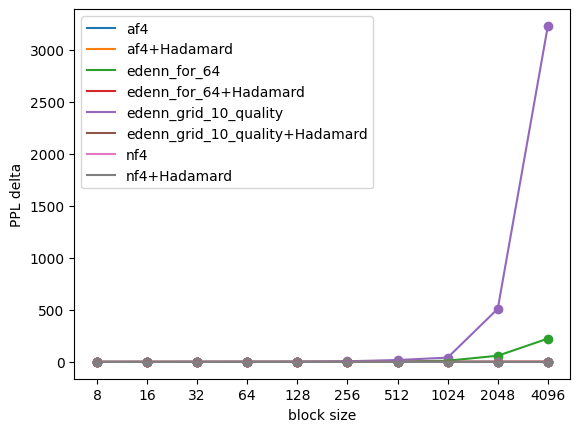

In [107]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

for name, hadamard in sorted(set(tuple(v) for v in data[['name', 'hadamard']].values)):
    to_plot = data
    to_plot = to_plot[to_plot['name'] == name]
    to_plot = to_plot[to_plot['hadamard'] == hadamard]
    label = name
    if hadamard:
        label += '+Hadamard'
    
    plt.plot(to_plot['block_size'], to_plot['ppl_increase'], label=label)
    plt.scatter(to_plot['block_size'], to_plot['ppl_increase'])

plt.ylabel('PPL delta')
plt.xscale('log')
plt.minorticks_off() 
ax.xaxis.set_ticks([8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
plt.xlabel('block size')
plt.legend()

In [108]:
from matplotlib import colormaps

/var/tmp/ipykernel_766996/2399952252.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(to_plot['block_size'], to_plot['ppl_increase'], c=color)


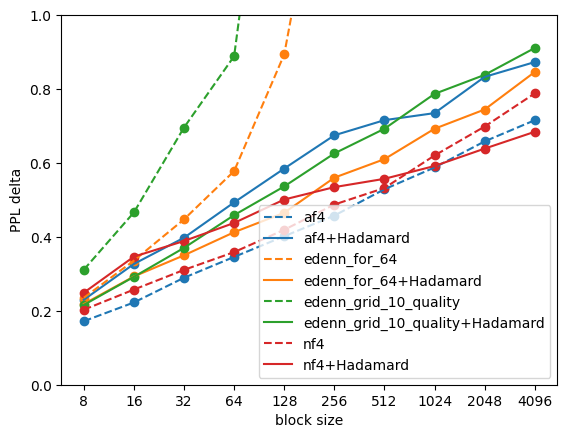

In [109]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

names_sorted = sorted(set(v for v in data['name'].values))

for name, hadamard in sorted(set(tuple(v) for v in data[['name', 'hadamard']].values)):
    to_plot = data
    to_plot = to_plot[to_plot['name'] == name]
    to_plot = to_plot[to_plot['hadamard'] == hadamard]
    label = name
    if hadamard:
        label += '+Hadamard'

    color_idx = names_sorted.index(name)
    color = colormaps['tab10'](color_idx)
    
    plt.plot(to_plot['block_size'], to_plot['ppl_increase'], '-' if hadamard else '--', label=label, c=color)
    plt.scatter(to_plot['block_size'], to_plot['ppl_increase'], c=color)

plt.ylabel('PPL delta')
plt.xscale('log')
plt.minorticks_off() 
ax.xaxis.set_ticks([8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
plt.xlabel('block size')
plt.ylim([0, 1])
plt.legend()

In [120]:
data[(data['name'] == 'af4')]

,name,hadamard,block_size,ppl_increase
0,af4,False,8,0.171884
3,af4,True,8,0.229895
6,af4,False,16,0.222570
9,af4,True,16,0.326772
12,af4,False,32,0.289474
15,af4,True,32,0.397719
18,af4,False,64,0.345841
21,af4,True,64,0.493295
24,af4,False,128,0.401741
27,af4,True,128,0.584863


In [121]:
BASE_PPL + 0.587801

6.194493790985107

In [54]:
# af4+hadamar 0.40107011795043945
# eden+hadamar 0.3985562324523926
# nf4+hadamar 0.4387364387512207

In [55]:
# af4 0.5006189346313477
# eden 0.5040278434753418
# nf4 0.35964202880859375
# af4+hadamar 0.40241146087646484
# eden+hadamar 0.40056753158569336
# nf4+hadamar 0.41819286346435547

In [56]:
# model_pt(torch.tensor([0])[:, None].cuda());

In [110]:
!git add *.ipynb *.py && git commit -m upd && git push

[galqiwi f930ec8] upd
 1 file changed, 414 insertions(+), 75 deletions(-)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Counting objects: 5, done.
Delta compression using up to 255 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 116.14 KiB | 936.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:galqiwi/linear-layer-compression.git
   974fd61..f930ec8  galqiwi -> galqiwi
